## 11장 OpenAI CLIP를 사용한 이미지 분류

### 사전 라이브러리 설치

In [1]:
!pip install transformers

In [5]:
!pip install torch

In [2]:
from transformers import CLIPProcessor, CLIPModel

# 모델과 프로세서 로드
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

### CLIP를 사용한 제로샷 분류하기

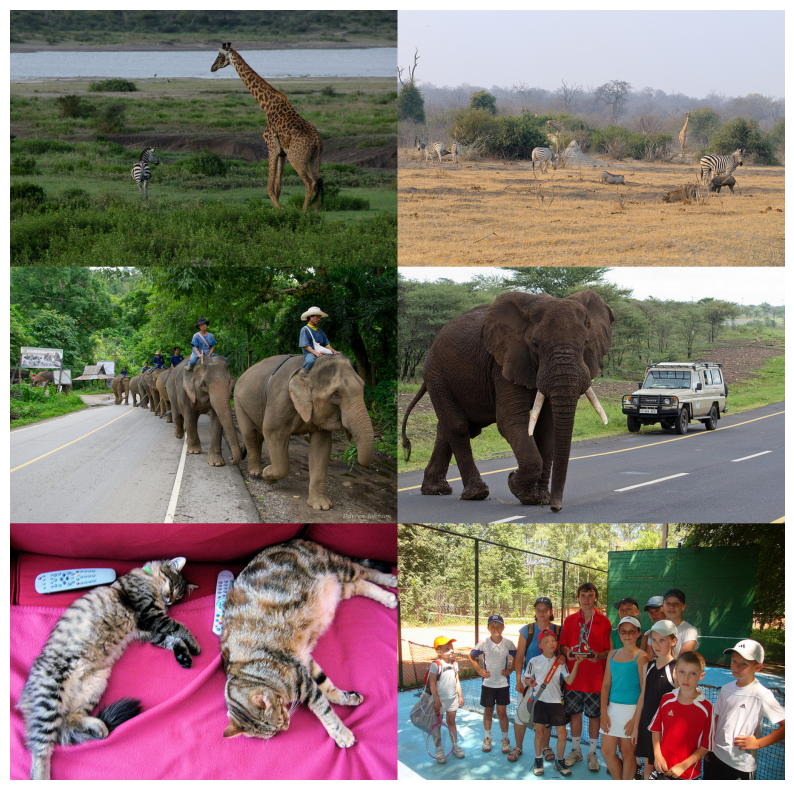

In [3]:
import requests
from PIL import Image
import matplotlib.pyplot as plt

def image_grid(imgs, cols):
    rows = (len(imgs) + cols - 1) // cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

# 이미지 URL 목록
image_urls = [
    'http://images.cocodataset.org/val2014/COCO_val2014_000000159977.jpg', # 기린
    'http://images.cocodataset.org/val2014/COCO_val2014_000000311295.jpg', # 얼룩말
    'http://images.cocodataset.org/val2014/COCO_val2014_000000457834.jpg', # 코끼리
    'http://images.cocodataset.org/val2014/COCO_val2014_000000555472.jpg', # 코끼리
    'http://images.cocodataset.org/val2017/000000039769.jpg',
    'http://images.cocodataset.org/val2017/000000001000.jpg',
]

# 이미지 로드
images = [Image.open(requests.get(url, stream=True).raw) for url in image_urls]

# 2x2 그리드 생성
grid = image_grid(images, cols=2)

# 구글 코랩에서 이미지 표시
plt.figure(figsize=(10,10))
plt.imshow(grid)
plt.axis('off')
plt.show()


### 레이브를 추가 후, 제로샷 분류 진행

In [8]:
# 제로샷 이미지 분류
# CLIP 모델을 사용한 이미지 분류 예제
import torch

# 분류할 동물 클래스 정의
classes = ['giraffe', 'zebra', 'elephant', 'person', 'toy']

# 텍스트와 이미지 전처리 및 모델 입력 형식 변환
inputs = processor(text=classes, images=images, return_tensors="pt", padding=True)

# 모델을 통해 이미지-텍스트 유사도 계산
outputs = model(**inputs)

# 이미지-텍스트 유사도 점수 추출
logits_per_image = outputs.logits_per_image

# 소프트맥스로 확률 분포 변환
probs = logits_per_image.softmax(dim=1)

# 확률을 소수점 2자리로 반올림하여 출력
print(torch.round(probs, decimals=2))

tensor([[0.8600, 0.1400, 0.0000, 0.0000, 0.0000],
        [0.3200, 0.2100, 0.4600, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0200, 0.0000, 0.9800, 0.0000, 0.0000],
        [0.0200, 0.0600, 0.0000, 0.1500, 0.7600],
        [0.0900, 0.0200, 0.0200, 0.7100, 0.1600]], grad_fn=<RoundBackward1>)


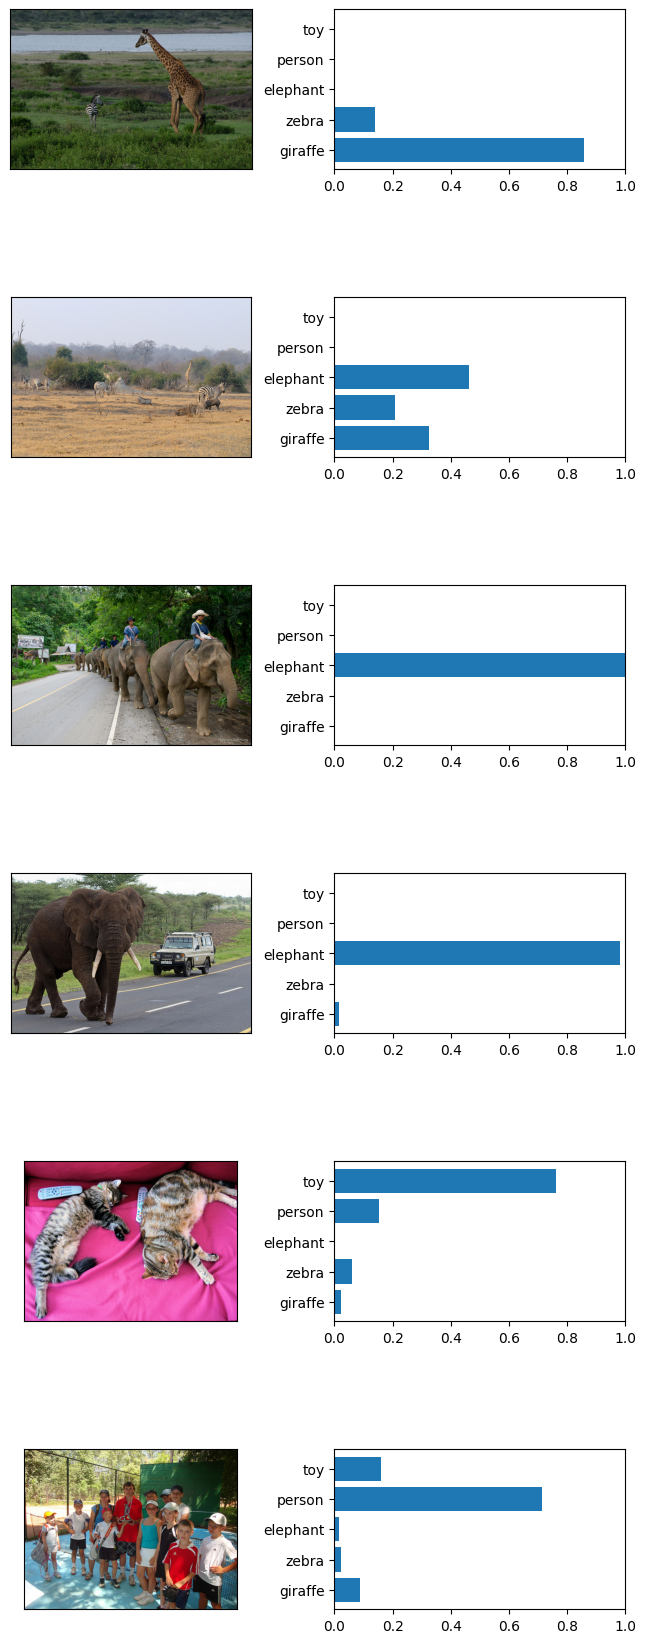

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 20))

for idx in range(len(images)):

    # show original image
    fig.add_subplot(len(images), 2, 2*(idx+1)-1 )
    plt.imshow(images[idx])
    plt.xticks([])
    plt.yticks([])

    # show probabilities
    fig.add_subplot(len(images), 2, 2*(idx+1))
    plt.barh(range(len(probs[0].detach().numpy())),probs[idx].detach().numpy(), tick_label=classes)
    plt.xlim(0,1.0)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.2,
                        hspace=0.8)

plt.show()

### 11-3 리버스 스테이블 디퓨전: 이미지에서 텍스트로 변환

In [10]:
!pip install clip-interrogator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 787.8/787.8 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.3 MB/s eta 0:00:00


In [ ]:
from PIL import Image
from clip_interrogator import Config, Interrogator

# 이미지 URL 지정
image_url = 'http://images.cocodataset.org/val2014/COCO_val2014_000000159977.jpg'

# 웹에서 이미지 다운로드 후, image01.jpg로 저장
image_path = 'image01.jpg'
response = requests.get(image_url, stream=True)
image = Image.open(response.raw).convert('RGB')

ci = Interrogator(Config(clip_model_name = "ViT-L-14/openai"))

print(ci.interrogate(image))

Loading caption model blip-large...


config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Loading CLIP model ViT-L-14/openai...


open_clip_model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/open_clip/factory.py:372: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(
ViT-L-14_openai_artists.safetensors: 100%|██████████| 16.2M/16.2M [00:00<00:00, 90.0MB/s]
ViT-L-14_openai_flavors.safetensors: 100%|██████████| 155M/155M [00:00<00:00, 191MB/s]
ViT-L-14_openai_mediums.safetensors: 100%|██████████| 146k/146k [00:00<00:00, 20.2MB/s]
ViT-L-14_openai_movements.safetensors: 100%|██████████| 307k/307k [00:00<00:00, 25.9MB/s]
ViT-L-14_openai_trendings.safetensors: 100%|██████████| 111k/111k [00:00<00:00, 28.0MB/s]
ViT-L-14_openai_negative.safetensors: 100%|██████████| 63.2k/63.2k [00:00<00:00, 55.4MB/s]


Loaded CLIP model and data in 26.68 seconds.


/usr/local/lib/python3.10/dist-packages/clip_interrogator/clip_interrogator.py:200: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  0%|          | 0/55 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/clip_interrogator/clip_interrogator.py:376: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 55/55 [00:00<00:00, 74.22it/s]
/usr/local/lib/python3.10/dist-packages/clip_interrogator/clip_interrogator.py:271: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cu

zebra and giraffe in a field with a lake in the background, towering above a small person, tall and slim, dynamic comparison, by Mark A. Brennan, daz occlusion, arguing, small legs, extremely contrast, antropomorphic
